In [26]:
import numpy as py
import matplotlib.pyplot as plt
from register import serial_init, serial_transmit, serial_receive

In [27]:
from g474 import *

In [28]:
TIM1.CCMR1

DEC: 0, HEX: 0x00000000

In [29]:
import time

def delay(ms):
    time.sleep(ms/1000)

与单片机程序配套的GPIO操作

In [30]:
def gpio(which, level):
    if level == 1:
        level = "1"
    else:
        level = "0"
    serial_transmit("GPIO:" + which + ":" + level)
    time.sleep(0.01)

In [31]:
SS_DAC = "PB9"
SS_595 = "PB8"

与单片机程序配套的SPI操作

In [32]:
def spi_mode(cpol, cpha):
    cpol = "1" if cpol==1 else "0"
    cpha = "1" if cpha==1 else "0"
    serial_transmit("SPI:M" + cpol + cpha)
    time.sleep(0.01)

In [33]:
def spi_write(data):
    serial_transmit("SPI:W".encode() + bytes(data))
    time.sleep(0.01)

DAC128S085指令

In [34]:
DAC_AFE1_OFF1 = 0
DAC_AFE1_OFF2 = 1

In [35]:
def ldac_init():
    spi_mode(0, 1)
    gpio(SS_DAC, 0)
    spi_write([9*16, 0])
    gpio(SS_DAC, 1)

ldac_init()

In [36]:
def ldac_set(which, value):
    spi_mode(0, 1)
    
    value = int(value)
    cmd = [which * 16 + value // 256, value % 256]
    
    gpio(SS_DAC, 0)
    spi_write(cmd)
    gpio(SS_DAC, 1)

利用74HC595控制模拟开关，从而调整增益

In [67]:
hc595_state = 0

def hc595_set():
    spi_mode(1, 1)
    spi_write([0])
    gpio(SS_595, 0)
    spi_write([hc595_state])
    gpio(SS_595, 1)

def hc595_afe(value):
    value = 7 - value
    global hc595_state
    hc595_state = (hc595_state & 0xF1) | (value << 1)
    hc595_set()

In [68]:
AFEPGA_GAIN_1 = 5
AFEPGA_GAIN_2 = 3
AFEPGA_GAIN_3 = 7
AFEPGA_GAIN_4 = 0
AFEPGA_GAIN_5 = 1
AFEPGA_GAIN_6 = 6

In [69]:

ADC1.SMPR1

DEC: 0, HEX: 0x00000000

In [70]:
sm_time = [2.5,6.5,12.5,24.5,47.5,92.5,247.5,640.5]
sys_clock =150e6
def set_sm_time(num):
    if num > 7:
        return -1
    else:
        ADC1.SMPR1.SMP6 = num
        print ("Set sample time to ", sm_time[num] * 1 / sys_clock * 10e9, "us")
        print("the total conversion time is" , (sm_time[num] + 12.5) * 1 / sys_clock * 10e9 , "us")
    

In [86]:
def i2c_write(addr, data):
    serial_transmit("I2C:W".encode() + bytes([0xC0, addr, data]))
    woshou_signal = serial_receive(1)
    if woshou_signal[0] == 0:
        print("I2C write success!")
    else:
        print("I2C write failed!")


def i2c_read(addr, length):
    serial_transmit("I2C:W".encode() + bytes([0xC0, addr]))
    woshou_signal = serial_receive(1)
    if woshou_signal[0] == 0:
        print("I2C write success!")
    else:
        print("I2C write failed!")
        return
    length = min(length, 16)
    serial_transmit("I2C:R".encode() + bytes([0xC0, length]))
    woshou_signal = serial_receive(length + 1)
    if woshou_signal[0] == 0:
        print("I2C read success!")
    else:
        print("I2C read failed!")
        return
    return woshou_signal[1:]

In [94]:
addr = 0
size = 10

serial_transmit("I2C:W".encode() + bytes([0xC0, addr]))
woshou_signal = serial_receive(1)
if woshou_signal[0] == 0:
    print("I2C write success!")
else:
    print("I2C write failed!")
print(woshou_signal)

I2C write success!
b'\x00'


In [95]:
length = 10
length = min(length, 16)
serial_transmit("I2C:R".encode() + bytes([0xC0, length]))
woshou_signal = serial_receive(length + 1)
if woshou_signal[0] == 0:
    print("I2C read success!")
else:
    print("I2C read failed!")
print(woshou_signal)
print(woshou_signal[1:])

I2C read success!
b'\x00a\xe8\x00\x00\x00\x00\x00\x00\x00\x00'
b'a\xe8\x00\x00\x00\x00\x00\x00\x00\x00'


In [89]:
bin(0xe1)

'0b11100001'

In [90]:
for i, b in enumerate(i2c_read(0, 10)):
    print(i, f"{b:08b}")

I2C write success!
I2C read failed!


TypeError: 'NoneType' object is not iterable

In [91]:
set_sm_time(0)
#ADC1.SMPR1

Set sample time to  166.66666666666666 us
the total conversion time is 1000.0 us


In [65]:
ldac_set(DAC_AFE1_OFF2, 500)
hc595_afe(AFEPGA_GAIN_3)

In [72]:
#sample = sm_1024()
#print(sample)
# Assuming serial_init has been called somewhere before to initialize the serial connection

def receive_data():
        gpio("PC0", 1)
        data1 = serial_receive(2050)  # Call the function to receive data
        #data2 = serial_receive(1025)  # Call the function to receive data
        #if data1 & data2:
            # Process the received data
        print("Received data:", data1)
        #print("Received data:", data2)
        gpio("PC0", 0)
        return data1

# Call the function to start receiving data
#serial_init()
samp_data = receive_data()

Received data: b't\x07\x9f\x07\xc6\x07\xef\x07\x1b\x08\\\x08\x8f\x08\xc6\x08\xfb\x086\tr\t\xaf\t\xef\t2\nu\n\xba\n\xff\nE\x0b\x8b\x0b\xcf\x0b\x13\x0cX\x0c\x9a\x0c\xdb\x0c\x1b\r[\r\x9b\r\xd5\r\r\x0eC\x0et\x0e\xa3\x0e\xcd\x0e\xcf\x0eg\x0e\x07\x0f\xe1\x0eA\x0e/\x0e\n\x0fS\x0e\xda\x0e\x8d\x0f\x87\x0fv\x0f\xa0\x0e0\x0e\n\x0e\xcd\x0e\xaa\x0e#\x0f\xeb\x0e\xc8\x0e\xcd\x0e\xa4\x0ev\x0eC\x0e\x0e\x0e\xd6\r\x9f\rb\r$\r\xe2\x0c\xa0\x0c[\x0c\x17\x0c\xd1\x0b\x8c\x0bH\x0b\x03\x0b\xbf\n{\n7\n\xf6\t\xb3\tt\t9\t\xfd\x08\xc5\x08\x91\x08_\x080\x08\x03\x08\xda\x07\xa3\x07\x83\x07c\x07K\x075\x07#\x07\x17\x07\x0f\x07\n\x07\n\x07\x0f\x07\x16\x07#\x075\x07I\x07b\x07\x80\x07\xa0\x07\xc5\x07\xef\x07\x1d\x08\\\x08\x8d\x08\xc3\x08\xf9\x084\to\t\xb0\t\xf0\t3\nx\n\xbb\n\xff\nD\x0b\x89\x0b\xcd\x0b\x11\x0cY\x0c\x9a\x0c\xdf\x0c \r_\r\x9b\r\xd6\r\x0c\x0eA\x0et\x0e\xa2\x0e\xca\x0e\xd2\x0e\xa8\x0e]\x0e\x18\x0f\xc5\x0ep\x0eL\x0e3\x0e\x88\x0e\x04\x0e\x10\x0e\xaa\x0e\t\x0ev\x0e\x12\x0eo\x0eT\x0e\x7f\x0e\x95\x0e\xfa\x0e\xc2\x0

In [73]:
def make_data(smp):
    data = [0] * int ( len(smp) / 2 )
    i = 0
    while i < int ( len(smp) / 2 ) :
        data[i] =  smp[2 * i]   | smp[2 * i + 1] << 8
        i = i + 1
    return data
sm_r_data = make_data(samp_data)
print(sm_r_data)

[1908, 1951, 1990, 2031, 2075, 2140, 2191, 2246, 2299, 2358, 2418, 2479, 2543, 2610, 2677, 2746, 2815, 2885, 2955, 3023, 3091, 3160, 3226, 3291, 3355, 3419, 3483, 3541, 3597, 3651, 3700, 3747, 3789, 3791, 3687, 3847, 3809, 3649, 3631, 3850, 3667, 3802, 3981, 3975, 3958, 3744, 3632, 3594, 3789, 3754, 3875, 3819, 3784, 3789, 3748, 3702, 3651, 3598, 3542, 3487, 3426, 3364, 3298, 3232, 3163, 3095, 3025, 2956, 2888, 2819, 2751, 2683, 2615, 2550, 2483, 2420, 2361, 2301, 2245, 2193, 2143, 2096, 2051, 2010, 1955, 1923, 1891, 1867, 1845, 1827, 1815, 1807, 1802, 1802, 1807, 1814, 1827, 1845, 1865, 1890, 1920, 1952, 1989, 2031, 2077, 2140, 2189, 2243, 2297, 2356, 2415, 2480, 2544, 2611, 2680, 2747, 2815, 2884, 2953, 3021, 3089, 3161, 3226, 3295, 3360, 3423, 3483, 3542, 3596, 3649, 3700, 3746, 3786, 3794, 3752, 3677, 3864, 3781, 3696, 3660, 3635, 3720, 3588, 3600, 3754, 3593, 3702, 3602, 3695, 3668, 3711, 3733, 3834, 3778, 3747, 3702, 3653, 3601, 3546, 3487, 3426, 3362, 3296, 3231, 3163, 3096, 302

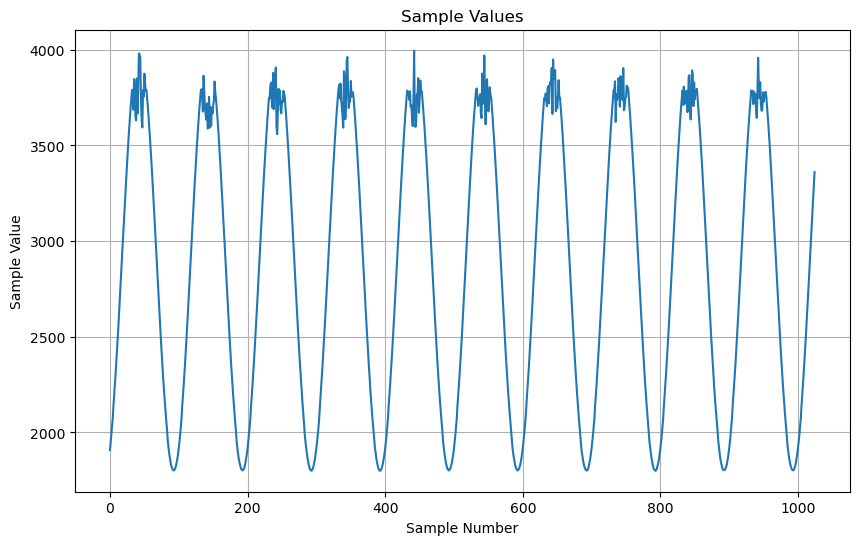

In [74]:
plt.figure(figsize=(10, 6))  # 创建一个新的图形，设置大小为10x6
plt.plot(sm_r_data)  # 使用plot函数绘制折线图
plt.title('Sample Values')  # 设置图形的标题
plt.xlabel('Sample Number')  # 设置x轴的标签
plt.ylabel('Sample Value')  # 设置y轴的标签
plt.grid(True)  # 显示网格
plt.show()  # 显示图形